# Conditional Variable Flow Matching: Extending Flow Matching to learn amortized conditional mappings

## Introduction

The original formulations of Flow Matching ([Lipman et al. (2023)](https://arxiv.org/abs/2210.02747)), including Stochastic Interpolants ([Albergo et al. (2023)](https://arxiv.org/abs/2209.15571)) and Rectified Flows ([Liu et al. (2023)](https://arxiv.org/abs/2209.03003)), have demonstrated a remarkable ability to train continuous normalizing flows (CNF) in a simulation-free manner. The core insight of these approaches lies in their ability to efficiently learn the dynamics transforming a base density to the data distribution, following an probability path specified by an ordinary differential equation (ODE). 

This notebook details our approach towards generalizing this efficient objective towards accepting conditional variables with continuous support.

## Flow Matching

CNFs define a contiuous map, taking data samples from a base distribution $x_0 \sim p(x_0)$ to a target distribution $x_1 \sim p(x_1)$ by learning a vector field $u: [0,1] \times \mathbb{R}^N \rightarrow \mathbb{R}^N$, defining a flow $\phi [0,1] \times \mathbb{R}^N \rightarrow \mathbb{R}^N$ according to the corresponding ordinary differential equation (ODE)

$$ \frac{d}{dt} \phi_t(x) = u_t(\phi_t(x)) ,\;\;\; \phi_0(x) = x. $$

This flow defines a push-forward operation
 
$$ p_t = \left[\phi_{t}\right]_{\#} p_{0} $$

transforming our base distribution $p_0$ at $t=0$ to  $p_1$ at $t=1$.

Not all vector fields satisfy this operation, specifically, only vector fields satisfying the continuity equation can be shown to generate the associated probability path $p_t$

$$ \frac{d}{dt} p_t(x) + \nabla_x (p_t(x)u_t(x)) = 0 $$

### Learning Objective

Flow matching circumvents regressing against the intractable marginal vector field $u_t(x)$ by introducing a conditional objective

$$ \mathcal{L}_{\textrm{CFM}}(\theta) = \mathbb{E}_{t, q(z), p_t(x|z)} \lVert v_\theta(x, t) - u_t(x | z) \rVert ^2 $$

where $q(z)$ defines the empirical distribution over observations $z = \{x_0, x_1\}$, $p_t(x|z)$ the conditional probability path between observations, and $u_t(x | z)$ the associated conditional vector field.

Interestingly, this way of combining conditional vector fields and their generated conditional probability paths can be shown to generate the correct marginal distributions. In particular, when Gaussian paths are taken, $p_t(x|z)=\mathcal{N}(x|\mu_t(z),\sigma_t^2(z))$ of $\phi_{t,z}(x) = \mu_t(z) + \sigma_t(z)x$ the unique conditional vector field $u_t(x|z)$ can be solved in closed form

$$ u_t(x|z) = \frac{\sigma'_t}{\sigma_t}(x - \mu_t) + \mu'_t. $$

In the case where $\mu_t(z) = t x_1 + (1 - t)x_0$ with constant $\sigma$ across time, the conditional vector field becomes $u_t(x|z) = x_1 - x_0$.


## Conditional Variable Flow Matching

A core limitation of this approach lies in its ability to only produce a singular probability path morphing an unconditional distribution $p_0 \rightarrow p_1$. Conditional Variable Flow Matching (CVFM) aims to directly address this limitation by producing an objective capable of learning conditional probability paths across the conditional data mainfold. 


The original marginalization motivating the flow matching objective can be extended to construct a probability flow across both $x$ and a conditioning variable $y$ as

$$  p_t(x | y) = \int p_t(x | y, z, w)q(z, w)dzdw $$

where $q(z,w)$ now denotes the empirical distribution over $z = (x_0, x_1)$ and $w = (y_0, y_1)$. We make the further assumption that the conditional joint probability path decomposes as $p_t(x, y| z, w) = p_t(x| z)p_t(y| w)$, resulting in two simultaneous conditional flows.

We can also extend this line of thought towards defining a marginal conditional vector field, through marginalizing over vector fields conditioned on observations $z$ and $w$ as

$$ u_t(x| y) = \mathbb{E}_{q(z, w)} \frac{u_t(x| z) p_t(x| z) p_t(y|w)}{p_t(x, y)} $$

where $u_t(x| z): \mathbb{R}^N  \rightarrow \mathbb{R}^N$ is a conditional vector field generating $p_t(x| z)$ from $p_0(x| z)$, without any explicit dependence upon the conditional distribution over our conditional variable, $y$.

$$ \mathcal{L}_{\textrm{CVFM}}(\theta) = \mathbb{E}_{t, q(z, w), p_t(x | z) p_t(y| w)} \lVert v_\theta(x, y, t) - u_t(x | z) \rVert^2 $$

### Conditional Optimal Transport

CVFM requires an optimal transport (OT) coupling in the empirical distribution $q(z, w)$, specifically across $y$ in order to satisfy the continuity equation. In other words, the mapping $q(y_0)$ to $q(y_1)$ must follow the coupling $\pi(y_0,y_1)$.

We would like to search for an OT map predominantly permitting movement across $\mathcal{X}$ and not $\mathcal{Y}$. In a very practical sense, given the continuous support of $\mathcal{Y}$, such a constraint would not be feasible within a finite number of samples. Instead, we moderate this requirement in the form of the proposed continuous non-negative cost function

$$ c((x_i,y_i),(x_j,y_j)) = \lVert x_i - x_j \rVert_p + \eta \lVert y_i - y_j \rVert_p $$

where $\eta > 0$ is a parameter governing the tolerance of transport permissible in $\mathcal{Y}$

To further facilitate conditional OT, a stationary kernel with support across the conditioning variable is introduced $\alpha(w) = \exp(-(y_0 - y_1)/{2\sigma_y^2})$, modulating the objective as

$$ \mathcal{L}_{\textrm{CVFM}}(\theta) = \mathbb{E}_{t, q(z, w), p_t(x | z) p_t(y| w)} \alpha(w) \lVert v_\theta(x, y, t) - u_t(x | z) \rVert^2 $$

The benefits of $\alpha(w)$ will become increasingly apparant in the 2D example below. We'll start by first importing the necessary packages, setting up the distributions we're going to sample, and our model.


In [1]:
import numpy as np
import ot as pot
import torch
import torchdyn
import torchsde
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

In [2]:
def sample_moons(n, theta):
    theta = np.radians(theta)
    rot_mat = torch.tensor([[np.cos(theta), -np.sin(theta)],
                             [np.sin(theta),  np.cos(theta)]],dtype=torch.float32)
    
    x0, y0 = generate_moons(n, noise=0.2)
    x0 = 3*(x0 - 0.5)
    x0 = torch.matmul(x0, rot_mat)
    return x0, y0

In [27]:
class MLP(torch.nn.Module):
    def __init__(self, dim, cdim, w=64):
        super().__init__()
        self.dim = dim
        self.cdim = cdim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + cdim + 1, w),
            torch.nn.GELU(),
            torch.nn.Linear(w, w),
            torch.nn.GELU(),
            torch.nn.Linear(w, w),
            torch.nn.GELU(),
            torch.nn.Linear(w, dim),
        )

    def forward(self, x, y, t):
        in_x = torch.cat([x, y, t], dim=-1)
        out = self.net(in_x)
        return out
    
class torchdyn_wrapper(torch.nn.Module):
    def __init__(self, model, y):
        super().__init__()
        self.model = model
        self.y = y
        
    def forward(self, t, x, args=None):  
        return self.model(x, self.y, t.repeat(x.shape[0])[:, None]) 

def plot_trajectories(traj, y):
    n = 2000
    y = y[:n].astype('int')
    
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(vmin=y.min(), vmax=y.max())
    colors = cmap(norm(y)) 
    
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black",zorder=5)
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=10, alpha=1, c="maroon",zorder=10)
    for i in range(n):
        plt.plot(traj[:, i, 0], traj[:, i, 1], color=colors[i], alpha=0.1,zorder=0)
    
    plt.legend([r"$p_0$", r"$p_1$", r"$x_{t} \vert x_{0}$"])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

def plot_couplings(x0,x1,y0,y1):
    plt.figure(figsize=(6, 6))
    plt.scatter(x0[:,0].detach().cpu().numpy(),x0[:,1].detach().cpu().numpy(), c="black")
    plt.scatter(x1[:,0].detach().cpu().numpy(),x1[:,1].detach().cpu().numpy(), c="maroon")
    plt.plot([x0[:,0].detach().cpu().numpy(),x1[:,0].detach().cpu().numpy()],[x0[:,1].detach().cpu().numpy(),x1[:,1].detach().cpu().numpy()], color="black", alpha=0.2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

### Conditional Optimal Transport: Practical Implementation Details

With the preliminaries out of the way, we'll take a closer look at specifically how we're going to re-sample from the coupling $\pi((x_0,y_0),(x_1,y_1))$ as opposed to the independent empirical distribution $q(x_0,y_0)q(x_1,y_1)$. To acomplish this, we'll build off of prior work by [Tong et al. (2023)](https://arxiv.org/abs/2302.00482) and [Pooladian et al. (2023)](https://arxiv.org/abs/2304.14772), specifically leveraging portions of the implementation by the former. Both works, proposed sampling minibatches from the optimal coupling, rather than independent empirical distributions as a means of obtaining marginal OT. As we saw earlier, CVFM extends this towards defining a ground cost over both $x$ and $y$, which neartly fits into this stochastic re-sampling.

We can take a closer look in isolation of this computation, and it's effect on pairings and consequently our target CVFM objective.

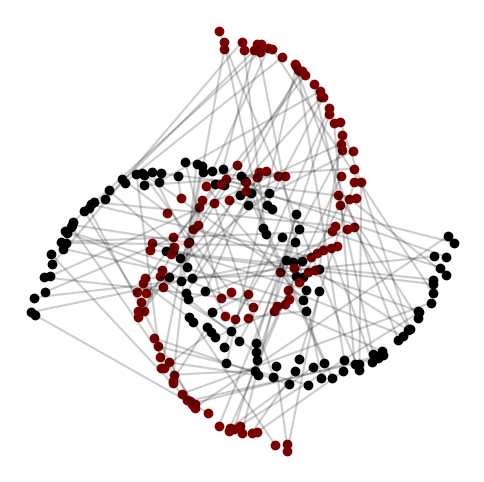

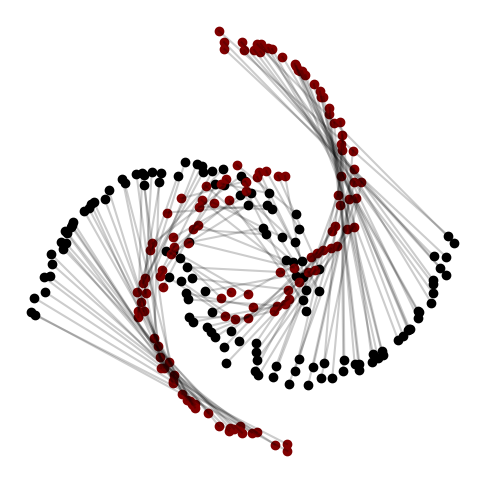

In [28]:
batch_size = 128
oty = 5

x0, y0 = sample_moons(batch_size, 0)
x1, y1 = sample_moons(batch_size, 270)
y0 = (x0[:,0] - 10)*(y0) + (1 - y0)*(x0[:,0] + 10)
    
y1 = y0
y0 = y0.unsqueeze(-1)
y1 = y1.unsqueeze(-1)

# Randomly shuffle to account for torchdyn ordered sampling
ind0 = torch.randperm(x0.size()[0])
ind1 = torch.randperm(x1.size()[0])
x0, y0 = x0[ind0].to(device), y0[ind0].to(device)
x1, y1 = x1[ind1].to(device), y1[ind1].to(device)  

# Plot couplings prior to conditional OT
plot_couplings(x0,x1,y0,y1)

# Resample xy0, xy1 according to transport matrix
a, b = pot.unif(batch_size), pot.unif(batch_size)
M = torch.cdist(x0, x1) ** 2 + oty*torch.cdist(y0, y1) ** 2
M = M / M.max()
pi = pot.emd(a, b, M.detach().cpu().numpy())
p = pi.flatten()
p = p / p.sum()
choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size, replace=False)
i, j = np.divmod(choices, pi.shape[1])   
x0 = x0[i]
x1 = x1[j]
y0 = y0[i] 
y1 = y1[j]

plot_couplings(x0,x1,y0,y1)

In [13]:
sigma = 0.1
sigmay = 0.5
oty = 5
dim = 2
cdim = 1
batch_size = 256

model = MLP(dim=dim, cdim=cdim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

2000: loss 0.075


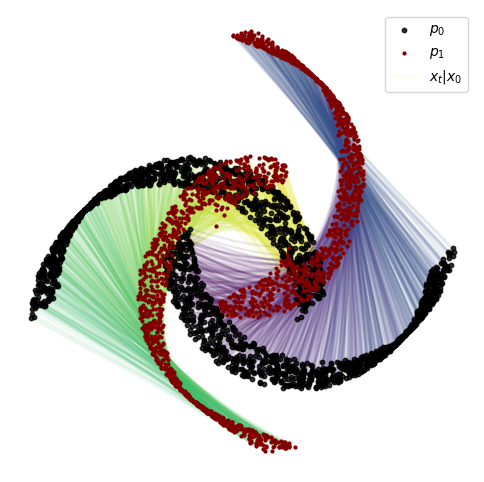

4000: loss 0.069


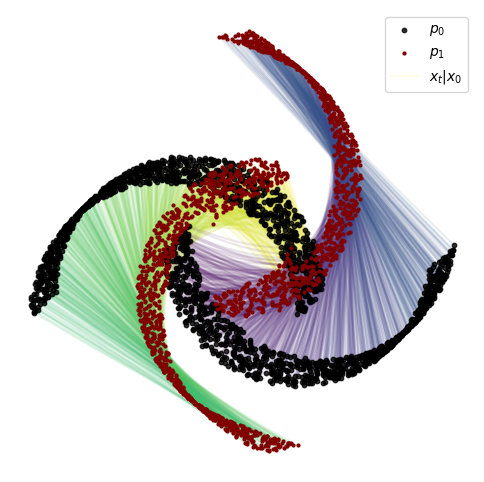

6000: loss 0.073


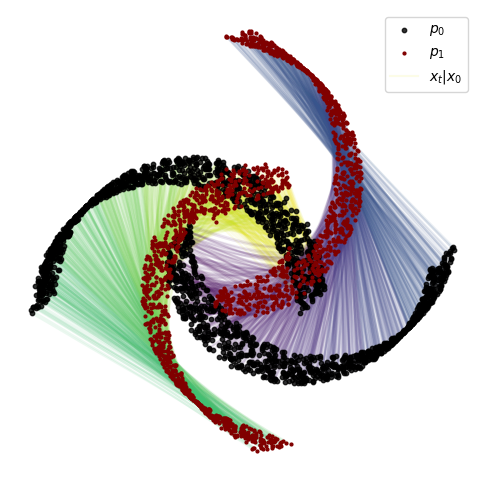

8000: loss 0.071


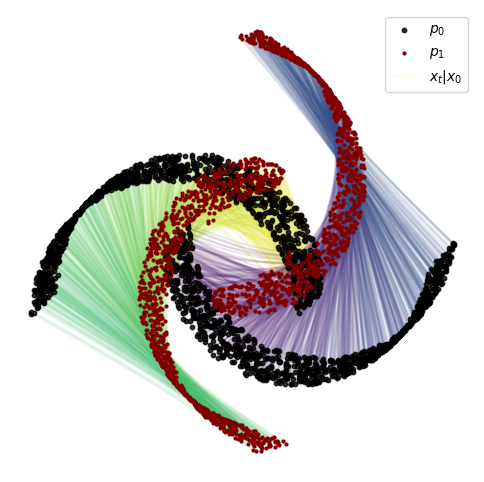

10000: loss 0.068


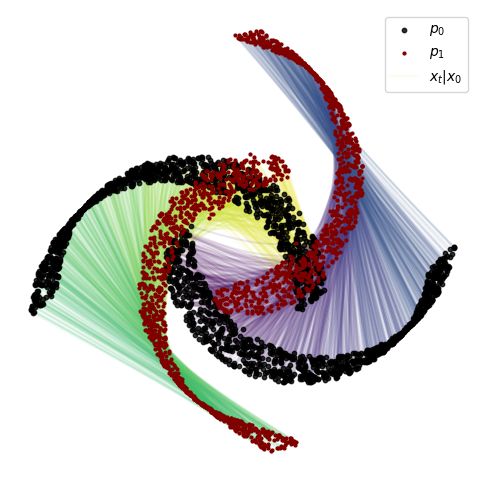

In [14]:
a, b = pot.unif(batch_size), pot.unif(batch_size)
for k in range(10000):
    optimizer.zero_grad()
    t = torch.randn(batch_size, 1).to(device)
    t = torch.nn.Sigmoid()(t)
    x0, y0 = sample_moons(batch_size, 0)
    x1, y1 = sample_moons(batch_size, 270)
    y0 = (x0[:,0] - 10)*(y0) + (1 - y0)*(x0[:,0] + 10)
        
    y1 = y0
    y0 = y0.unsqueeze(-1)
    y1 = y1.unsqueeze(-1)
    
    # Randomly shuffle to account for torchdyn ordered sampling
    ind0 = torch.randperm(x0.size()[0])
    ind1 = torch.randperm(x1.size()[0])
    x0, y0 = x0[ind0].to(device), y0[ind0].to(device)
    x1, y1 = x1[ind1].to(device), y1[ind1].to(device)  
    
    # Resample xy0, xy1 according to transport matrix
    M = torch.cdist(x0, x1) ** 2 + oty*torch.cdist(y0, y1) ** 2
    M = M / M.max()
    pi = pot.emd(a, b, M.detach().cpu().numpy())
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size, replace=False)
    i, j = np.divmod(choices, pi.shape[1])   
    x0 = x0[i]
    x1 = x1[j]
    y0 = y0[i] 
    y1 = y1[j]

    # calculate regression loss
    mu_t = x0 * (1 - t) + x1 * t
    muy_t = y0 * (1 - t) + y1 * t
    
    x = mu_t + sigma * torch.randn_like(x0).to(device)
    y = muy_t + sigmay * torch.randn_like(y0).to(device)
    
    ut = x1 - x0
    vt = model(x, y, t)  

    # SE kernel in conditioning variable
    yerr = torch.exp(-0.5 * ((y1 - y0) / sigmay) ** 2)

    loss = torch.mean(yerr * (vt - ut) ** 2) 
    loss.backward()
    optimizer.step()
    
    if (k + 1) % 2000 == 0:
        print(f"{k+1}: loss {loss.item():0.3f}")

        x0, y0 = sample_moons(2048, 0)
        x0, y0 = x0.to(device), y0.to(device)
        y0 = (x0[:,0] - 10)*(y0) + (1 - y0)*(x0[:,0] + 10)
        node = NeuralODE(
            torchdyn_wrapper(model, y0.unsqueeze(-1)), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        ).to(device)
        
        with torch.no_grad():
            traj = node.trajectory(
                x0,
                t_span=torch.linspace(0, 1, 100),
            )

            plot_trajectories(traj.detach().cpu().numpy(), y0.detach().cpu().numpy())